In [2]:
import getpass
import os

if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('articles.csv')

In [5]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'article_id'}, inplace=True)

In [6]:
df['article_name'].nunique()

477

In [7]:
embeddings_model = "text-embedding-3-large"

In [8]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
)

In [9]:
from langchain.docstore.document import Document

In [10]:
df["docs"] = df.apply(
    lambda x: Document(
        page_content=x['article_name'],
        metadata={
            'article_id': x['article_id']
        }
    ),
    axis=1,
)

In [11]:
from langchain.text_splitter import CharacterTextSplitter

In [12]:
lst_documents = df["docs"].tolist()

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,
    chunk_overlap=20,
)

split_docs = text_splitter.split_documents(lst_documents)

In [13]:
# ADD NORMALIZATION?

In [14]:
from langchain.vectorstores import FAISS
from langchain_core.vectorstores import InMemoryVectorStore

In [15]:
vector_store = FAISS.from_documents(
    documents=split_docs, embedding=embeddings
)

In [16]:
docs = vector_store.similarity_search("como acho um produto?", k=10)

In [17]:
docs

[Document(id='d98a9085-5755-4e14-8f77-32fce1ef9987', metadata={'article_id': 380}, page_content='Como pesquisar produtos no Mercado da Hotmart?'),
 Document(id='4e9fcb87-f5b0-4524-b0e6-dc35f26ad202', metadata={'article_id': 186}, page_content='Como cadastrar meu produto?'),
 Document(id='45bb2ee2-5035-4ace-8e18-253237f6bef1', metadata={'article_id': 398}, page_content='Como acessar o produto que comprei?'),
 Document(id='2059b6bc-3580-465a-abb6-0f035b12373b', metadata={'article_id': 419}, page_content='Busca de produto Hotmart'),
 Document(id='51d7fef2-bf0d-4cf5-991d-985711f5da6e', metadata={'article_id': 59}, page_content='Como encontrar as mídias de divulgação do produto?'),
 Document(id='1715c274-331a-47a0-bc09-e477b3db0e16', metadata={'article_id': 470}, page_content='Como cadastrar um produto de evento online?'),
 Document(id='7fed1f4f-c6c1-4949-b72d-60dcec07e4da', metadata={'article_id': 308}, page_content='Como comprar um produto pela Hotmart?'),
 Document(id='44ad57df-1447-4749

In [18]:
from typing import Literal, TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])
# Output:
# Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, ...)

# Simulate resuming with human input
# To test rejection, replace resume="approve" with resume="reject"
# final_result = graph.invoke(Command(resume="approve"), config=config)
# print(final_result)

[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, resumable=True, ns=['human_approval:46adc8fe-2056-b084-a51e-12f54f55f887'])]


In [19]:
final_result = graph.invoke(Command(resume="approve"), config=config)
print(final_result)

✅ Approved path taken.
{'llm_output': 'This is the generated output.', 'decision': 'approved'}


In [20]:
retriever = vector_store.as_retriever()

In [21]:
from langchain.tools.retriever import create_retriever_tool


retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_faq_articles",
    "Search and return FAQ articles about Hotmart.",
)

In [22]:
retriever_tool.invoke({"query": "achar produtos"})

'Busca de produto Hotmart\n\nComo pesquisar produtos no Mercado da Hotmart?\n\nComo favoritar produtos no Mercado de Afiliação\n\nComo cadastrar meu produto?'

In [93]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("openai:gpt-4.1", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [94]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

grader_model = init_chat_model("openai:gpt-4.1", temperature=0)

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [95]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [96]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [97]:
class State(TypedDict):
    llm_output: str
    decision: str


# Human approval node
def human_approval(state: MessagesState) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Essa resposta foi útil?",
        "message": state['messages'][-1]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Usuário aprovou a resposta!")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Procure um assistente")
    return state

In [98]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

In [144]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
subgraph = workflow.compile(checkpointer=checkpointer)

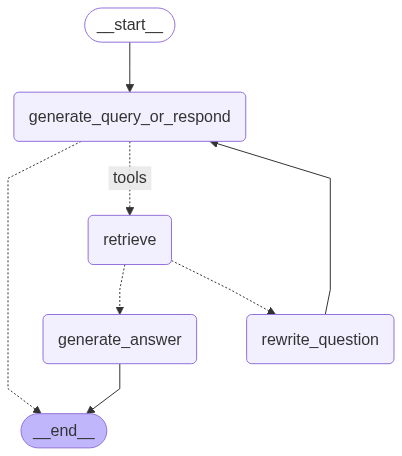

In [145]:
from IPython.display import Image, display

display(Image(subgraph.get_graph().draw_mermaid_png()))

In [74]:
# for chunk in graph.stream(
#     {
#         "messages": [
#             {
#                 "role": "user",
#                 "content": "Como achar produtos na Hotmart?",
#             }
#         ]
#     }
# ):
#     for node, update in chunk.items():
#         print("Update from node", node)
#         update["messages"][-1].pretty_print()
#         print("\n\n")

In [103]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = subgraph.invoke({
        "messages": [
            {
                "role": "user",
                "content": "Como achar produtos na Hotmart?",
            }
        ]
    }, config=config)

In [104]:
print(result["__interrupt__"])

[Interrupt(value={'question': 'Essa resposta foi útil?', 'message': AIMessage(content='Para achar produtos na Hotmart, acesse o Mercado da Hotmart e utilize a barra de busca para pesquisar pelo nome, nicho ou palavra-chave do produto desejado. Você também pode filtrar os resultados por categoria ou popularidade. Assim, encontrará diversas opções disponíveis para promover ou comprar.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 97, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-Bv7p9vqzuYzwNG5YMjy6gkqOa9faV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a22d4c66-bf89-4c1f-afac-15d2738c2fbd-0', usage_metadata={'input_tokens': 97

In [106]:
final_result = subgraph.invoke(Command(resume="reject"), config=config)
print(final_result)

❌ Procure um assistente
{'messages': [HumanMessage(content='Como achar produtos na Hotmart?', additional_kwargs={}, response_metadata={}, id='91060f36-e492-4de7-b441-0ab7c0a39792'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jemZBE5a32vmDnDnPRaR8N5K', 'function': {'arguments': '{"query":"como encontrar produtos na Hotmart"}', 'name': 'retrieve_faq_articles'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 64, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-Bv7p7bx00h8nJUMvjjHBUIkqYcrW4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--134241b7-b82b-4255-baad-2e0cfae27c40-0', tool_calls=[{'name': 'retr

In [107]:
final_result['messages'][-1]

AIMessage(content='Para achar produtos na Hotmart, acesse o Mercado da Hotmart e utilize a barra de busca para pesquisar pelo nome, nicho ou palavra-chave do produto desejado. Você também pode filtrar os resultados por categoria ou popularidade. Assim, encontrará diversas opções disponíveis para promover ou comprar.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 97, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-Bv7p9vqzuYzwNG5YMjy6gkqOa9faV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a22d4c66-bf89-4c1f-afac-15d2738c2fbd-0', usage_metadata={'input_tokens': 97, 'output_tokens': 59, 'total_tokens': 156, 'input_token_details': {

In [135]:
class State(TypedDict):
    llm_output: str
    decision: str


# Human approval node
def human_approval(state: MessagesState) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Essa resposta foi útil?",
        "message": state['messages'][-1]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Usuário aprovou a resposta!")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Procure um assistente")
    return state

In [136]:
QUESTION_GRADE_PROMPT = (
    "You are a grader assessing if a question is related with Hotmart customer support. \n "
    "Here is the user question: {question} \n"
    "If the question contains keyword(s) or semantic meaning related to Hotmart customer support, grade it as related. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the question is related with customer support or not."
)


class GradeQuestion(BaseModel):
    """Grade questions using a binary score for customer support related check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if related, or 'no' if not related"
    )


def grade_questions(
    state: MessagesState,
) -> Literal["agentic_rag", "out_of_context_path"]:
    """Determine whether the user question is related to Hotmart customer support."""
    question = state["messages"][0].content

    prompt = QUESTION_GRADE_PROMPT.format(question=question)
    response = (
        grader_model
        .with_structured_output(GradeQuestion).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print(score)

    return "agentic_rag" if score.lower() == "yes" else "out_of_context_path"
    
def out_of_context_node(state: MessagesState) -> MessagesState:
    print("❌ Apenas posso responder a perguntas referentes à Hotmart")
    return state

def call_subgraph(state: MessagesState):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    response = subgraph.invoke({
            "messages": state["messages"]
        }, config=config)
    return {"messages": response["messages"]}

from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START


builder = StateGraph(MessagesState)
builder.add_node("supervisor", supervisor_node)
builder.add_node("agentic_rag", call_subgraph)
builder.add_node("out_of_context_path", out_of_context_node)
builder.add_node(human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)


builder.add_edge(START, "supervisor")
builder.add_conditional_edges(
    "supervisor",
    # Assess agent decision
    grade_questions,
)
builder.add_edge("agentic_rag", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)
builder.add_edge("out_of_context_path", END)


graph = builder.compile()

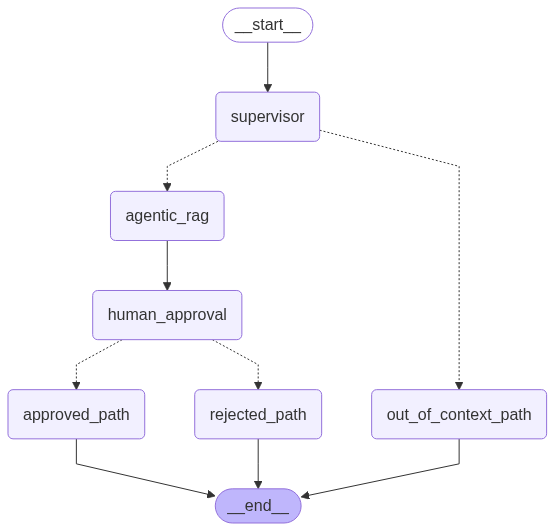

In [137]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [138]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Como usar o Recuperador Automático de Vendas?",
        }
    ]
}, config=config)

yes


In [142]:
result['messages'][-1].content.strip()

'Para usar o Recuperador Automático de Vendas, acesse a ferramenta na sua plataforma e escolha o tipo de recuperação desejada (assinatura, boleto, PIX parcelado ou pagamento híbrido). Configure as regras e mensagens automáticas que serão enviadas aos clientes para incentivar a finalização da compra. Salve as configurações e ative o recuperador para que ele funcione automaticamente conforme definido.'

In [143]:
print(result["__interrupt__"])

[Interrupt(value={'question': 'Essa resposta foi útil?', 'message': AIMessage(content='Para usar o Recuperador Automático de Vendas, acesse a ferramenta na sua plataforma e escolha o tipo de recuperação desejada (assinatura, boleto, PIX parcelado ou pagamento híbrido). Configure as regras e mensagens automáticas que serão enviadas aos clientes para incentivar a finalização da compra. Salve as configurações e ative o recuperador para que ele funcione automaticamente conforme definido.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 127, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-Bv8H86i5YyJWpQ8tVAANIf16Q5k0F', 'service_tier': 'default', 'finish_reason': 'stop',